# Titanic - Machine Learning Project (UT)
---

In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

---

## Plan

1) **Input Data** - for importing our train and test data set.

2) **Data Exploration** - for exploring our train data set 

3) **Feature Engineering** - for merging and removing columns

4) **Data Processing** - preparing data for model fitting

---

### Input Data

In [2]:
os.listdir('inputs/')

['test.csv', 'train.csv']

In [3]:
train_df = pd.read_csv("./inputs/train.csv")
test_df = pd.read_csv("./inputs/test.csv")

In [4]:
data_list = [train_df, test_df]

In [5]:
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


---

### Data Exploration

In [8]:
print(f"Train data is {train_df.shape[0]} rows, with {train_df.shape[1]} columns")
print(f"Test data is {test_df.shape[0]} rows, with {test_df.shape[1]} columns")

Train data is 891 rows, with 12 columns
Test data is 418 rows, with 11 columns


In [9]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [10]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [11]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [12]:
numeric_columns = train_df[['Age','SibSp','Parch','Fare']]
categorical_columns = train_df[['Survived','Pclass','Sex','Ticket','Cabin','Embarked']]

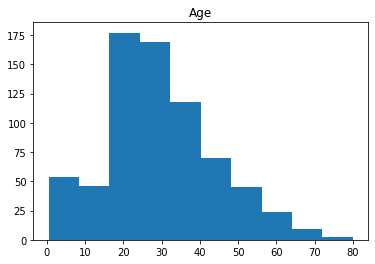

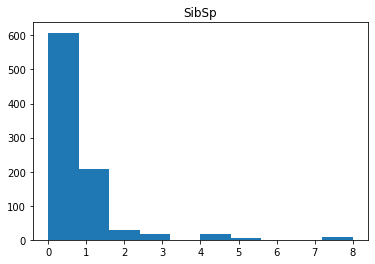

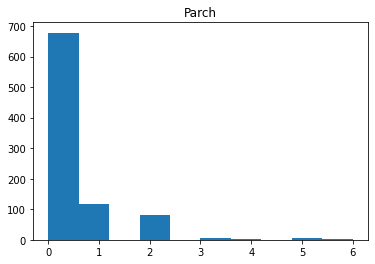

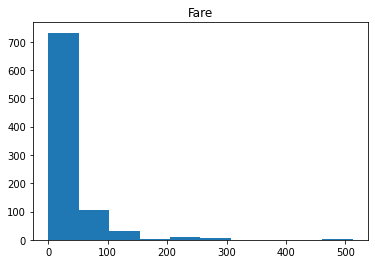

In [13]:
for i in numeric_columns.columns:
    plt.hist(numeric_columns[i])
    plt.title(i)
    plt.show()

In [14]:
pd.pivot_table(train_df, index = 'Survived', values = ['Age','SibSp','Parch','Fare'])

,Age,Fare,Parch,SibSp
Survived,,,,
0,30.626179,22.117887,0.329690,0.553734
1,28.343690,48.395408,0.464912,0.473684


In [15]:
pd.pivot_table(train_df, index = 'Survived', columns = 'Pclass', values = 'PassengerId' ,aggfunc ='count')


Pclass,1,2,3
Survived,,,
0,80,97,372
1,136,87,119


In [16]:
pd.pivot_table(train_df, index = 'Survived', columns = 'Sex', values = 'PassengerId' ,aggfunc ='count')


Sex,female,male
Survived,,
0,81,468
1,233,109


In [17]:
pd.pivot_table(train_df, index = 'Survived', columns = 'Embarked', values = 'PassengerId' ,aggfunc ='count')


Embarked,C,Q,S
Survived,,,
0,75,47,427
1,93,30,217


In [18]:
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


<AxesSubplot:>

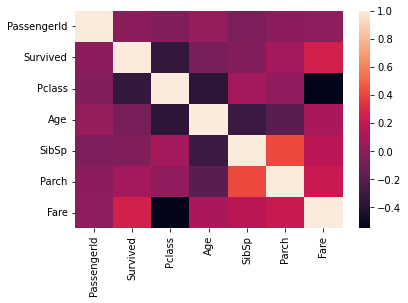

In [19]:
sns.heatmap(train_df.corr())

In [20]:
for place in train_df['Embarked'].unique()[0:3]:
    place_count = len(train_df[(train_df.Embarked == place)])
    a = len(train_df)
    print(f"Number of people from {place} are {place_count*100/a}%")

Number of people from S are 72.27833894500561%
Number of people from C are 18.855218855218855%
Number of people from Q are 8.641975308641975%


## Feature Engineering
---

In [21]:
# Merging Parent Children and Sibling Spouse to FamilyOnBoard
train_df['FamilyOnBoard']= train_df.SibSp + train_df.Parch
test_df['FamilyOnBoard']= test_df.SibSp + test_df.Parch

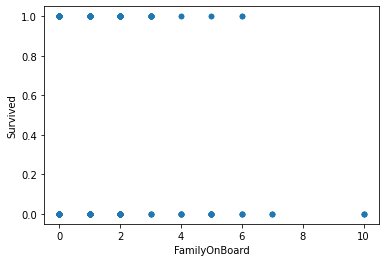

In [22]:
plot = train_df.plot.scatter('FamilyOnBoard','Survived')

In [23]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    object 
 4   Sex            891 non-null    object 
 5   Age            714 non-null    float64
 6   SibSp          891 non-null    int64  
 7   Parch          891 non-null    int64  
 8   Ticket         891 non-null    object 
 9   Fare           891 non-null    float64
 10  Cabin          204 non-null    object 
 11  Embarked       889 non-null    object 
 12  FamilyOnBoard  891 non-null    int64  
dtypes: float64(2), int64(6), object(5)
memory usage: 90.6+ KB


In [24]:
train_df['cabin_adv'] = train_df.Cabin.apply(lambda x: str(x)[0])
test_df['cabin_adv'] = test_df.Cabin.apply(lambda x: str(x)[0])

In [25]:
pd.pivot_table(train_df,index='Survived',columns='cabin_adv', values = 'Name', aggfunc='count')

cabin_adv,A,B,C,D,E,F,G,T,n
Survived,,,,,,,,,
0,8.0,12.0,24.0,8.0,8.0,5.0,2.0,1.0,481.0
1,7.0,35.0,35.0,25.0,24.0,8.0,2.0,NaN,206.0


### Data Processing

---


In [26]:
train_df = train_df.drop(labels='Parch', axis=1)
test_df = test_df.drop(labels='Parch', axis=1)

train_df = train_df.drop(labels='SibSp', axis=1)
test_df = test_df.drop(labels='SibSp', axis=1)

In [27]:
def fill_empty_Median(dataFrame, column, groupColumns ):
    dataFrame[column] = dataFrame[column].fillna(dataFrame.groupby(groupColumns)[column].transform('median'))
    return dataFrame[column]

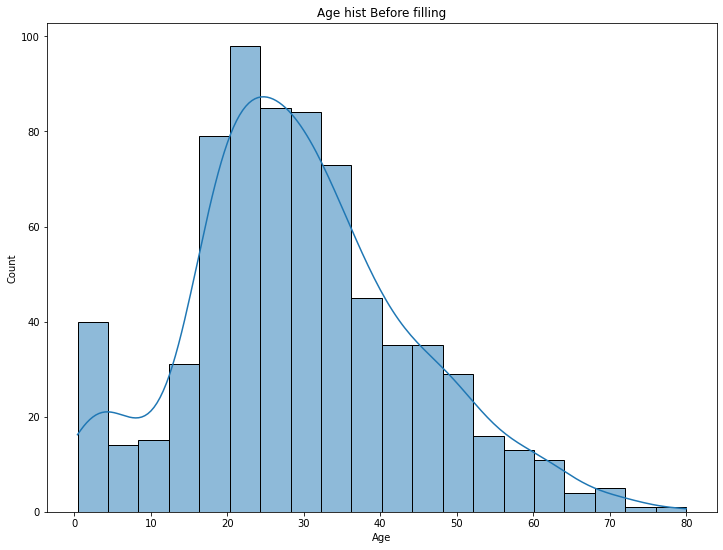

In [28]:
fig = plt.figure(figsize = (12,9))
sns.histplot(train_df["Age"], kde=True, palette='BuPu_r')
plt.title('Age hist Before filling')
plt.show()

In [29]:
train_df['Age'] = fill_empty_Median(train_df, "Age", ['FamilyOnBoard', 'Sex', 'Pclass', 'Fare'])
train_df['Age'] = train_df['Age'].fillna(train_df['Age'].median())

test_df['Age'] = fill_empty_Median(test_df, "Age", ['FamilyOnBoard', 'Sex', 'Pclass', 'Fare'])
test_df['Age'] = test_df['Age'].fillna(test_df['Age'].median())

In [30]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    object 
 4   Sex            891 non-null    object 
 5   Age            891 non-null    float64
 6   Ticket         891 non-null    object 
 7   Fare           891 non-null    float64
 8   Cabin          204 non-null    object 
 9   Embarked       889 non-null    object 
 10  FamilyOnBoard  891 non-null    int64  
 11  cabin_adv      891 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 83.7+ KB


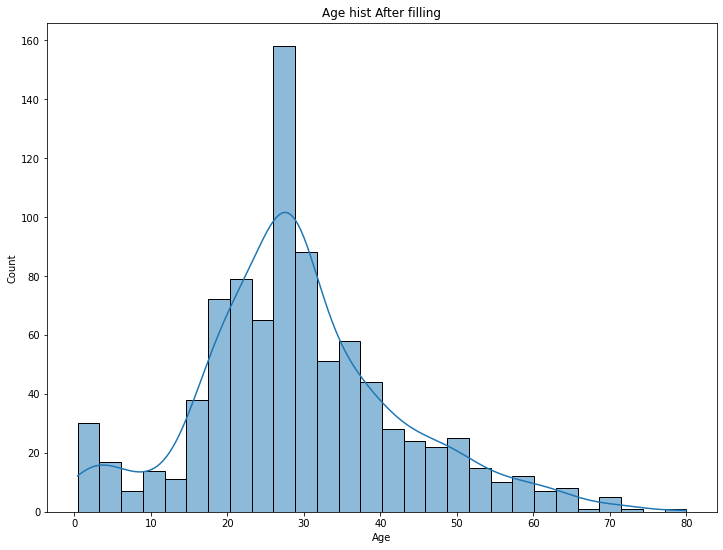

In [31]:
fig = plt.figure(figsize = (12,9))
sns.histplot(train_df["Age"], kde=True, palette='BuPu_r')
plt.title('Age hist After filling')
plt.show()

In [32]:
train_df = train_df.drop(labels='Cabin', axis=1)
test_df = test_df.drop(labels='Cabin', axis=1)

In [33]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    891 non-null    int64  
 1   Survived       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   Name           891 non-null    object 
 4   Sex            891 non-null    object 
 5   Age            891 non-null    float64
 6   Ticket         891 non-null    object 
 7   Fare           891 non-null    float64
 8   Embarked       889 non-null    object 
 9   FamilyOnBoard  891 non-null    int64  
 10  cabin_adv      891 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 76.7+ KB


In [34]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   PassengerId    418 non-null    int64  
 1   Pclass         418 non-null    int64  
 2   Name           418 non-null    object 
 3   Sex            418 non-null    object 
 4   Age            418 non-null    float64
 5   Ticket         418 non-null    object 
 6   Fare           417 non-null    float64
 7   Embarked       418 non-null    object 
 8   FamilyOnBoard  418 non-null    int64  
 9   cabin_adv      418 non-null    object 
dtypes: float64(2), int64(3), object(5)
memory usage: 32.8+ KB


In [35]:
test_df.Fare = test_df.Fare.fillna(train_df.Fare.median())

### Building Models

---

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

In [37]:
features = ['Pclass', "Sex", 'Age', "Fare", "Embarked", "FamilyOnBoard", 'cabin_adv', 'Survived']

#split valid train set into train and validation parts
train_df = pd.get_dummies(train_df[features])

train_df, train_df_val = train_test_split(train_df, random_state = 111, test_size = 0.20)

y = train_df["Survived"]
x = train_df.drop(columns=['Survived'])

y_val = train_df_val["Survived"]
x_val = train_df_val.drop(columns=['Survived'])

features.remove("Survived")

test_x = pd.get_dummies(test_df[features])

In [38]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 167 to 852
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         712 non-null    int64  
 1   Age            712 non-null    float64
 2   Fare           712 non-null    float64
 3   FamilyOnBoard  712 non-null    int64  
 4   Survived       712 non-null    int64  
 5   Sex_female     712 non-null    uint8  
 6   Sex_male       712 non-null    uint8  
 7   Embarked_C     712 non-null    uint8  
 8   Embarked_Q     712 non-null    uint8  
 9   Embarked_S     712 non-null    uint8  
 10  cabin_adv_A    712 non-null    uint8  
 11  cabin_adv_B    712 non-null    uint8  
 12  cabin_adv_C    712 non-null    uint8  
 13  cabin_adv_D    712 non-null    uint8  
 14  cabin_adv_E    712 non-null    uint8  
 15  cabin_adv_F    712 non-null    uint8  
 16  cabin_adv_G    712 non-null    uint8  
 17  cabin_adv_T    712 non-null    uint8  
 18  cabin_ad

In [39]:
train_df_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 374 to 640
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         179 non-null    int64  
 1   Age            179 non-null    float64
 2   Fare           179 non-null    float64
 3   FamilyOnBoard  179 non-null    int64  
 4   Survived       179 non-null    int64  
 5   Sex_female     179 non-null    uint8  
 6   Sex_male       179 non-null    uint8  
 7   Embarked_C     179 non-null    uint8  
 8   Embarked_Q     179 non-null    uint8  
 9   Embarked_S     179 non-null    uint8  
 10  cabin_adv_A    179 non-null    uint8  
 11  cabin_adv_B    179 non-null    uint8  
 12  cabin_adv_C    179 non-null    uint8  
 13  cabin_adv_D    179 non-null    uint8  
 14  cabin_adv_E    179 non-null    uint8  
 15  cabin_adv_F    179 non-null    uint8  
 16  cabin_adv_G    179 non-null    uint8  
 17  cabin_adv_T    179 non-null    uint8  
 18  cabin_ad

In [40]:
lr = LogisticRegression(max_iter=2000)
cv = cross_val_score(lr,x,y,cv=5)

print('-'*40)
for val in enumerate(cv):
    print(f"Accuracy #{val[0]}: {val[1]} ")

print('-'*40)
print(f"Mean value: {cv.mean()}")
x.info()

----------------------------------------
Accuracy #0: 0.7762237762237763 
Accuracy #1: 0.7272727272727273 
Accuracy #2: 0.852112676056338 
Accuracy #3: 0.7676056338028169 
Accuracy #4: 0.8309859154929577 
----------------------------------------
Mean value: 0.7908401457697233
<class 'pandas.core.frame.DataFrame'>
Int64Index: 712 entries, 167 to 852
Data columns (total 18 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Pclass         712 non-null    int64  
 1   Age            712 non-null    float64
 2   Fare           712 non-null    float64
 3   FamilyOnBoard  712 non-null    int64  
 4   Sex_female     712 non-null    uint8  
 5   Sex_male       712 non-null    uint8  
 6   Embarked_C     712 non-null    uint8  
 7   Embarked_Q     712 non-null    uint8  
 8   Embarked_S     712 non-null    uint8  
 9   cabin_adv_A    712 non-null    uint8  
 10  cabin_adv_B    712 non-null    uint8  
 11  cabin_adv_C    712 non-null    uint8  


In [41]:
knn = KNeighborsClassifier()
cv = cross_val_score(knn,x,y,cv=5)

print('-'*40)
for val in enumerate(cv):
    print(f"Accuracy #{val[0]}: {val[1]} ")

print('-'*40)
print(f"Mean value: {cv.mean()}")

----------------------------------------
Accuracy #0: 0.7272727272727273 
Accuracy #1: 0.7062937062937062 
Accuracy #2: 0.7535211267605634 
Accuracy #3: 0.6830985915492958 
Accuracy #4: 0.7253521126760564 
----------------------------------------
Mean value: 0.7191076529104697


In [42]:
rfc = RandomForestClassifier(n_estimators=100, max_depth=3, random_state=1)

cv = cross_val_score(rfc, x, y, cv=5)

print('-'*40)
for val in enumerate(cv):
    print(f"Accuracy #{val[0]}: {val[1]} ")

print('-'*40)
print(f"Mean value: {cv.mean()}")

----------------------------------------
Accuracy #0: 0.8111888111888111 
Accuracy #1: 0.7902097902097902 
Accuracy #2: 0.8309859154929577 
Accuracy #3: 0.7605633802816901 
Accuracy #4: 0.8098591549295775 
----------------------------------------
Mean value: 0.8005614104205652


In [43]:
svc = SVC(probability = True)
cv = cross_val_score(svc,x,y,cv=5)

print('-'*40)
for val in enumerate(cv):
    print(f"Accuracy #{val[0]}: {val[1]} ")

print('-'*40)
print(f"Mean value: {cv.mean()}")

----------------------------------------
Accuracy #0: 0.6643356643356644 
Accuracy #1: 0.6643356643356644 
Accuracy #2: 0.676056338028169 
Accuracy #3: 0.704225352112676 
Accuracy #4: 0.6830985915492958 
----------------------------------------
Mean value: 0.6784103220722939


In [47]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state =1)
cv = cross_val_score(xgb,x,y,cv=5)

print('-'*40)
for val in enumerate(cv):
    print(f"Accuracy #{val[0]}: {val[1]} ")

print('-'*40)
print(f"Mean value: {cv.mean()}")

[21:38:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:33] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[21:38:34] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be